In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
out_dir = os.path.join(data_dir, 'results/LogisticRegressionCV_PCA_Healthy_v_ACVD_Jie_only')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Study Accession"].isin(['PRJEB21528']).to_numpy()
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(282, 38)

In [7]:
SampleMeta["Phenotype"].value_counts()

ACVD           152
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

In [8]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(282, 903)

In [9]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [10]:
X = MatrixData

In [11]:
y = SampleMeta['Phenotype'].to_numpy().astype('str') == 'ACVD'
y = y.astype('int64')

In [12]:
pd.value_counts(SampleMeta['Phenotype'])

ACVD           152
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

# Define and Train Model

In [13]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

retrain = True
n_splits = 10
out_path = os.path.join(out_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(out_dir):
        os.system('rm -rf ' + out_dir)
    os.mkdir(out_dir)
    # random seed here deals with model initialization
    MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
                                         solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
                                        scoring=metrics.make_scorer(RECALL_SCORE))
    # setup pipeline and Trainer
    MyPipeLine = Pipeline([('scaler0', StandardScaler()), ('pca', PCA(n_components=100))])
    MyTrainer = Trainer(model = MyLogistic, pipeline_X=MyPipeLine)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()
    


Running for split 1 of 10
Using predict_proba
getting predictions from probs
Running for split 2 of 10
Using predict_proba
getting predictions from probs
Running for split 3 of 10
Using predict_proba
getting predictions from probs
Running for split 4 of 10
Using predict_proba
getting predictions from probs
Running for split 5 of 10
Using predict_proba
getting predictions from probs
Running for split 6 of 10
Using predict_proba
getting predictions from probs
Running for split 7 of 10
Using predict_proba
getting predictions from probs
Running for split 8 of 10
Using predict_proba
getting predictions from probs
Running for split 9 of 10
Using predict_proba
getting predictions from probs
Running for split 10 of 10
Using predict_proba
getting predictions from probs


In [14]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.806183,train
1,0.848646,train
2,0.781912,train
3,0.818985,train
4,0.826638,train
5,0.826638,train
6,0.802600,train
7,0.774869,train
8,0.795228,train
9,0.726000,train


<AxesSubplot:xlabel='stage', ylabel='score'>

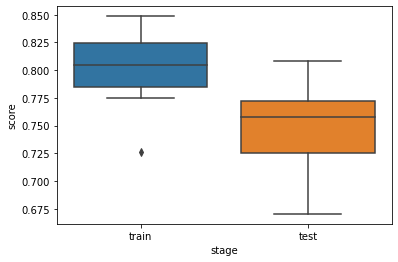

In [15]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [16]:
MyMultiTrainTester.TrainerList[0].model.Cs_

array([2.20264658e+04, 8.10308393e+03, 2.98095799e+03, 1.09663316e+03,
       4.03428793e+02, 1.48413159e+02, 5.45981500e+01, 2.00855369e+01,
       7.38905610e+00, 2.71828183e+00, 1.00000000e+00, 3.67879441e-01,
       1.35335283e-01, 4.97870684e-02, 1.83156389e-02, 6.73794700e-03,
       2.47875218e-03, 9.11881966e-04, 3.35462628e-04, 1.23409804e-04])

In [17]:
hyperparams = {'l1_ratio': [], 'C': []}
for i in range(n_splits):
    hyperparams['l1_ratio'].append(MyMultiTrainTester.TrainerList[i].model.l1_ratio_)
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.C_)

In [18]:
pd.DataFrame(hyperparams)

,l1_ratio,C
0,[0.9],[0.049787068367863944]
1,[0.2],[0.01831563888873418]
2,[0.30000000000000004],[0.01831563888873418]
3,[0.1],[0.006737946999085467]
4,[0.0],[0.0009118819655545162]
5,[0.0],[0.00033546262790251185]
6,[0.9],[0.049787068367863944]
7,[0.4],[0.01831563888873418]
8,[0.4],[0.01831563888873418]
9,[0.5],[0.01831563888873418]


<AxesSubplot:xlabel='score_type', ylabel='value'>

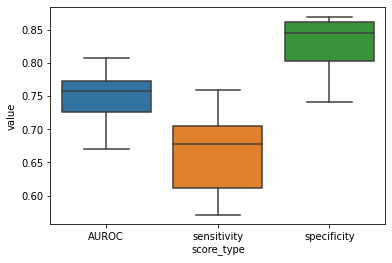

In [19]:
def AUROC_SCORE(y_true, y_pred):
    return metrics.roc_auc_score(y_true, y_pred, average='macro')
def SENSITIVITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=1)
def SPECIFICITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=0)

scorer_list = [AUROC_SCORE, SENSITIVITY_SCORE, SPECIFICITY_SCORE]
scorer_names = ['AUROC', 'sensitivity', 'specificity']
other_metrics = {'split': [], 'score_type': [], 'value': []}
for i in range(n_splits):
    test_idx = MyMultiTrainTester.test_idx[i]
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    Trainer_i = MyMultiTrainTester.TrainerList[i]
    for j in range(len(scorer_list)):
        score_type = scorer_names[j]
        score_func = scorer_list[j]
        other_metrics['split'].append(i)
        other_metrics['score_type'].append(score_type)
        other_metrics['value'].append(Trainer_i.score(X_test, y_test, score_func))
    
other_metrics_df = pd.DataFrame(other_metrics)
sns.boxplot(data = other_metrics_df, x = 'score_type', y = 'value')

In [20]:
# median sensitivity
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'sensitivity'])

0.6781609195402298

In [21]:
# median specificity
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'specificity'])

0.8452380952380952

In [22]:
other_metrics_df.to_csv(os.path.join(out_dir, 'misc_score_metrics.csv'))

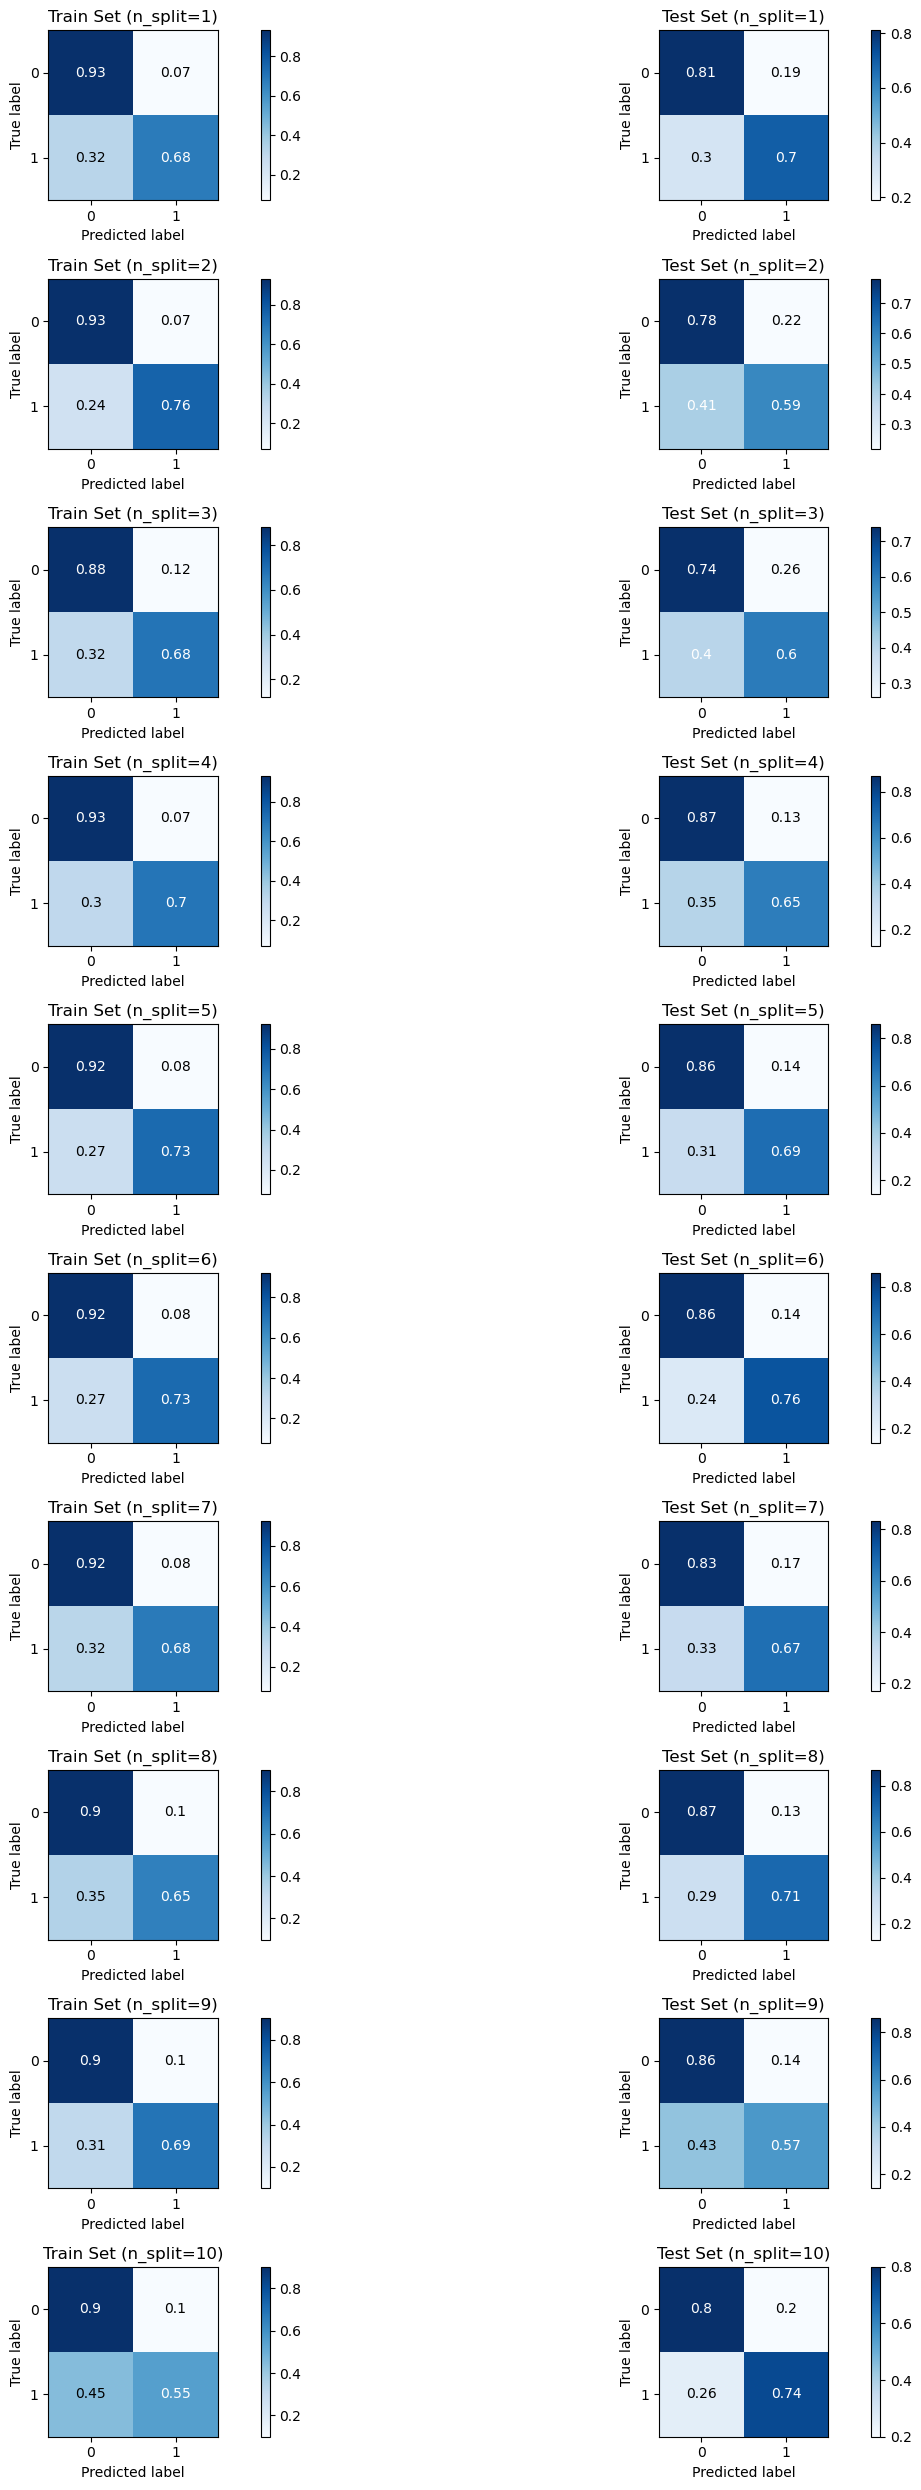

In [23]:
MyMultiTrainTester.plot_confusion(normalize=True, figsize=(15,25))

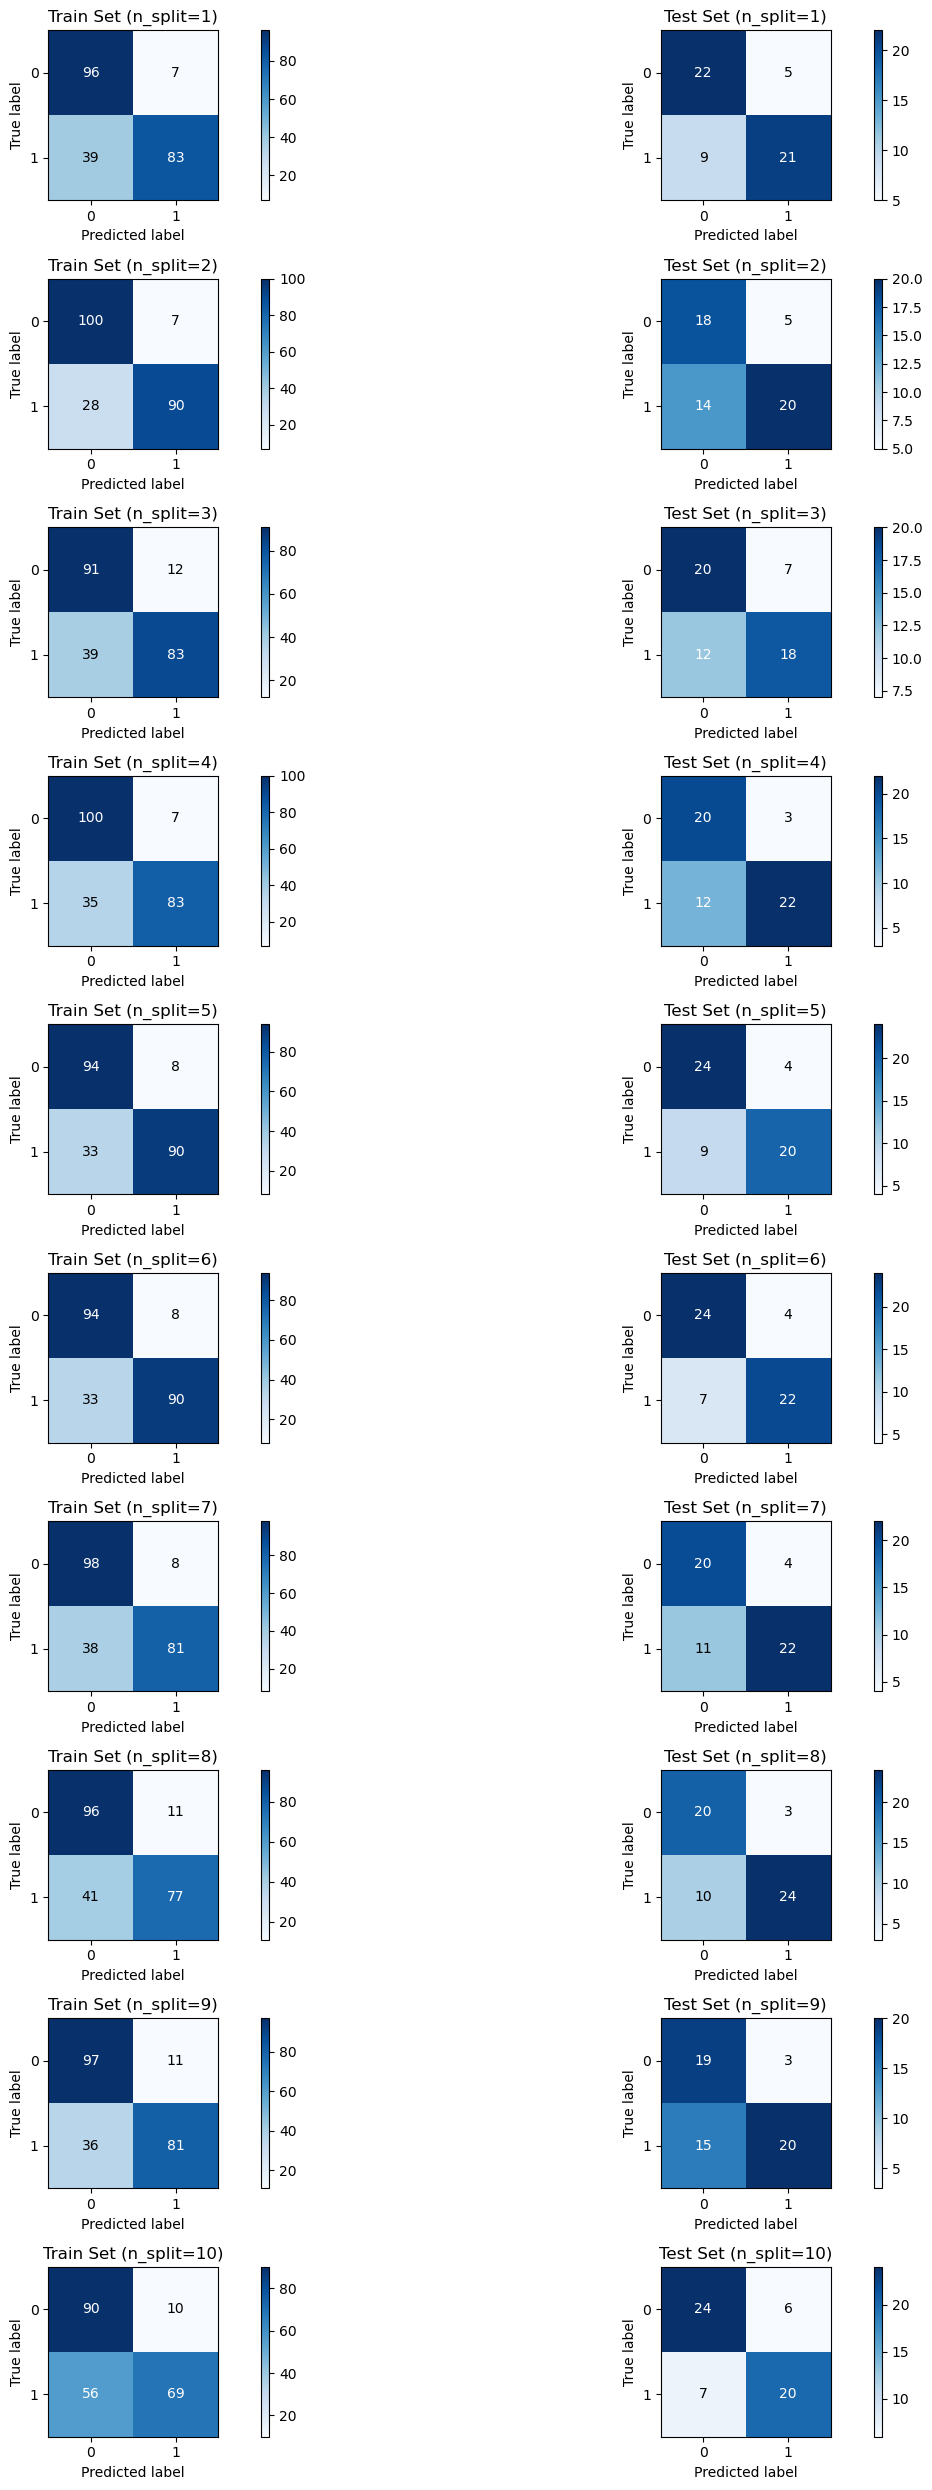

In [24]:
MyMultiTrainTester.plot_confusion(normalize=False, figsize=(15,25))

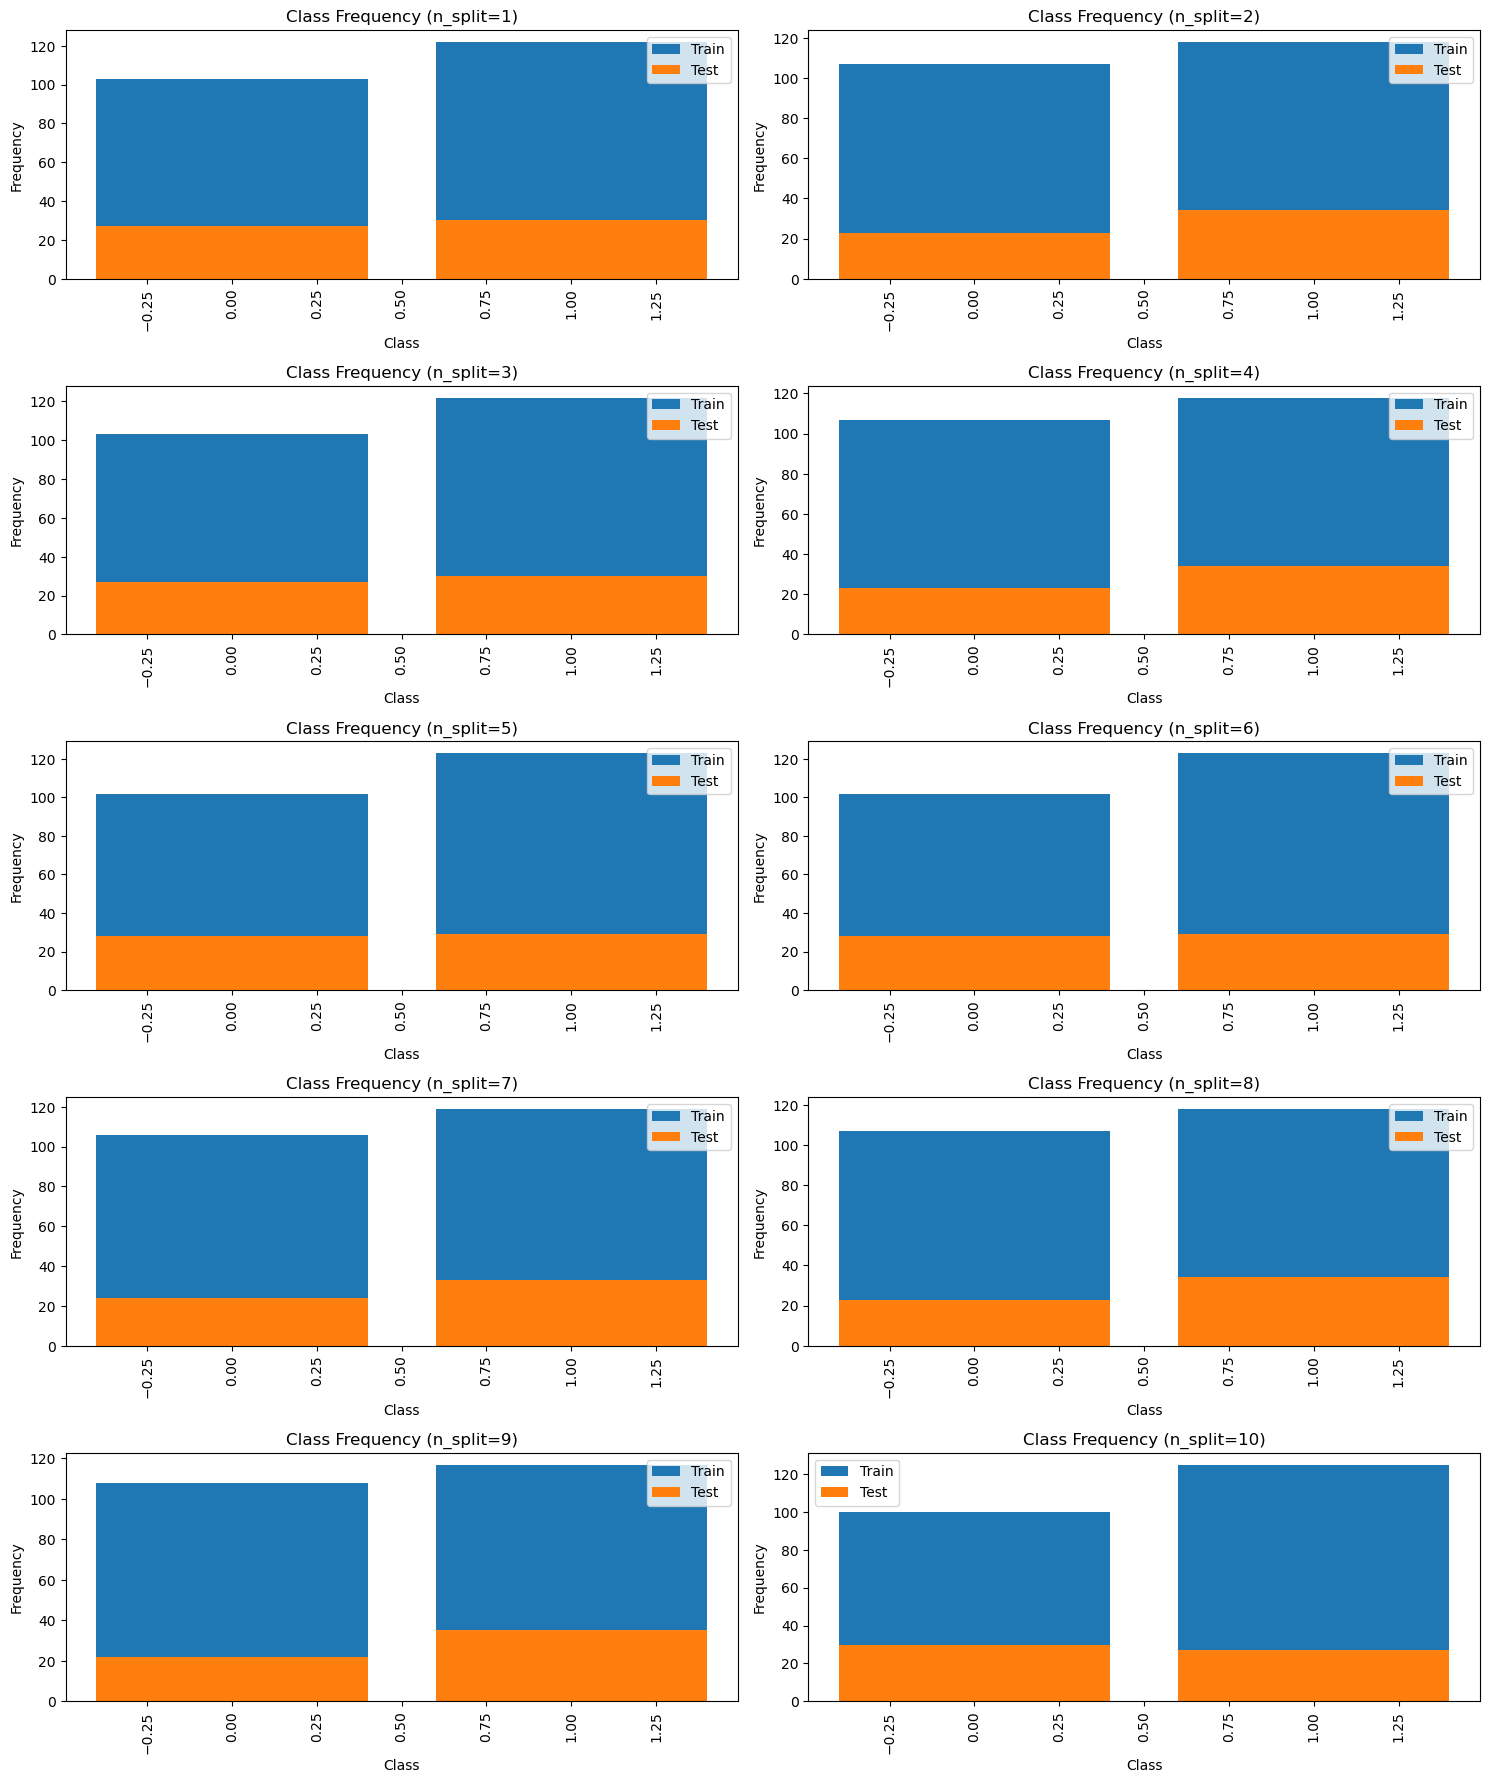

In [25]:
MyMultiTrainTester.plot_class_freq(normalize=True, figsize=(15,35))

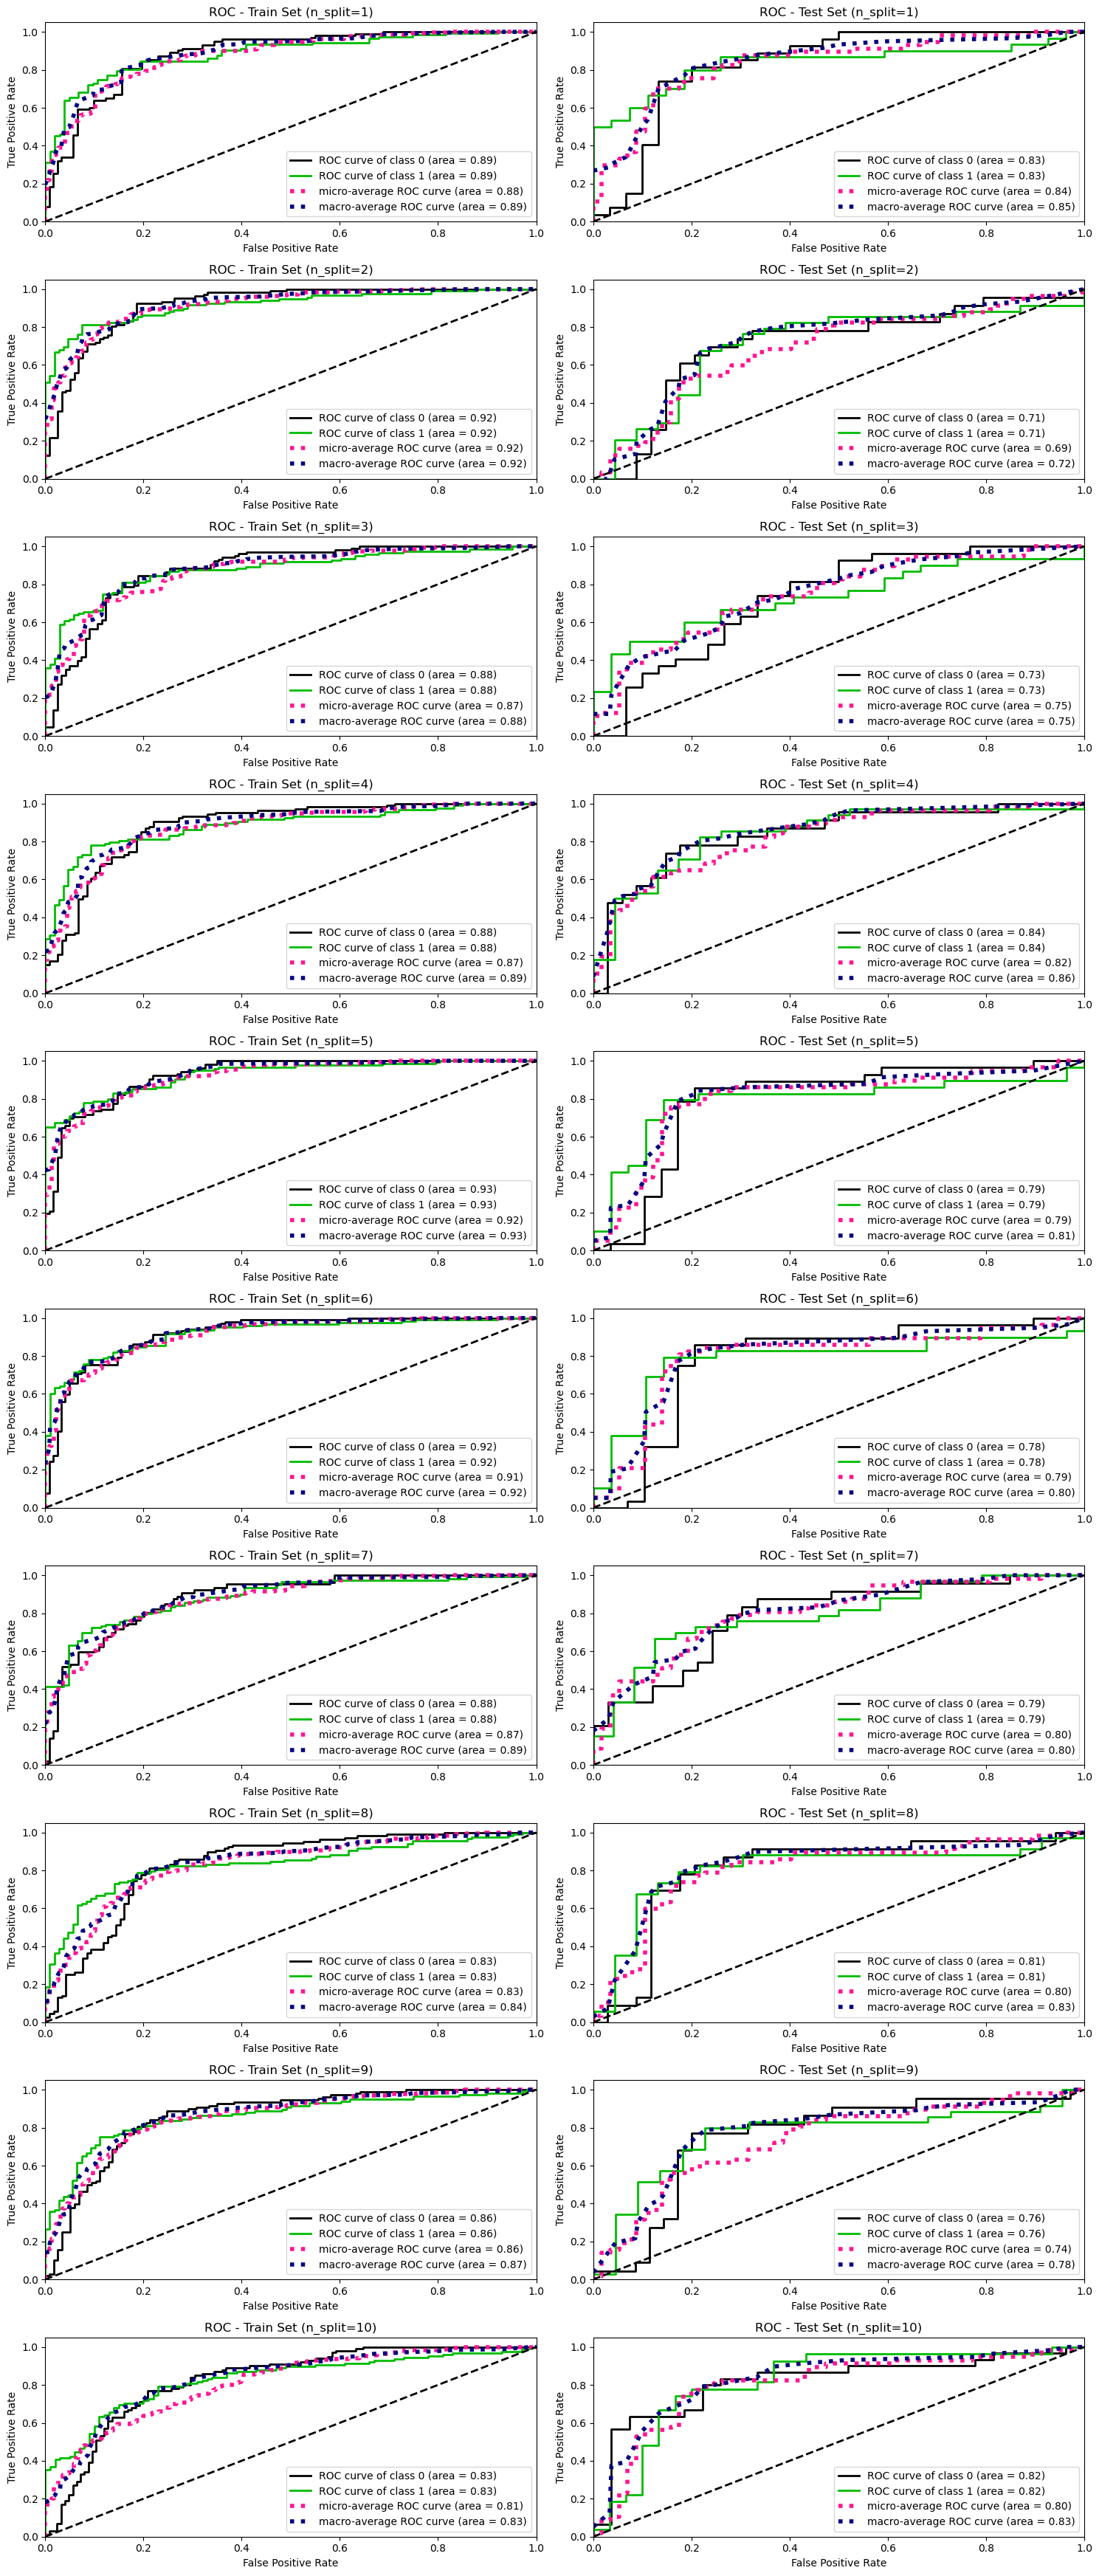

In [26]:
MyMultiTrainTester.plot_roc(figsize=(15,35))

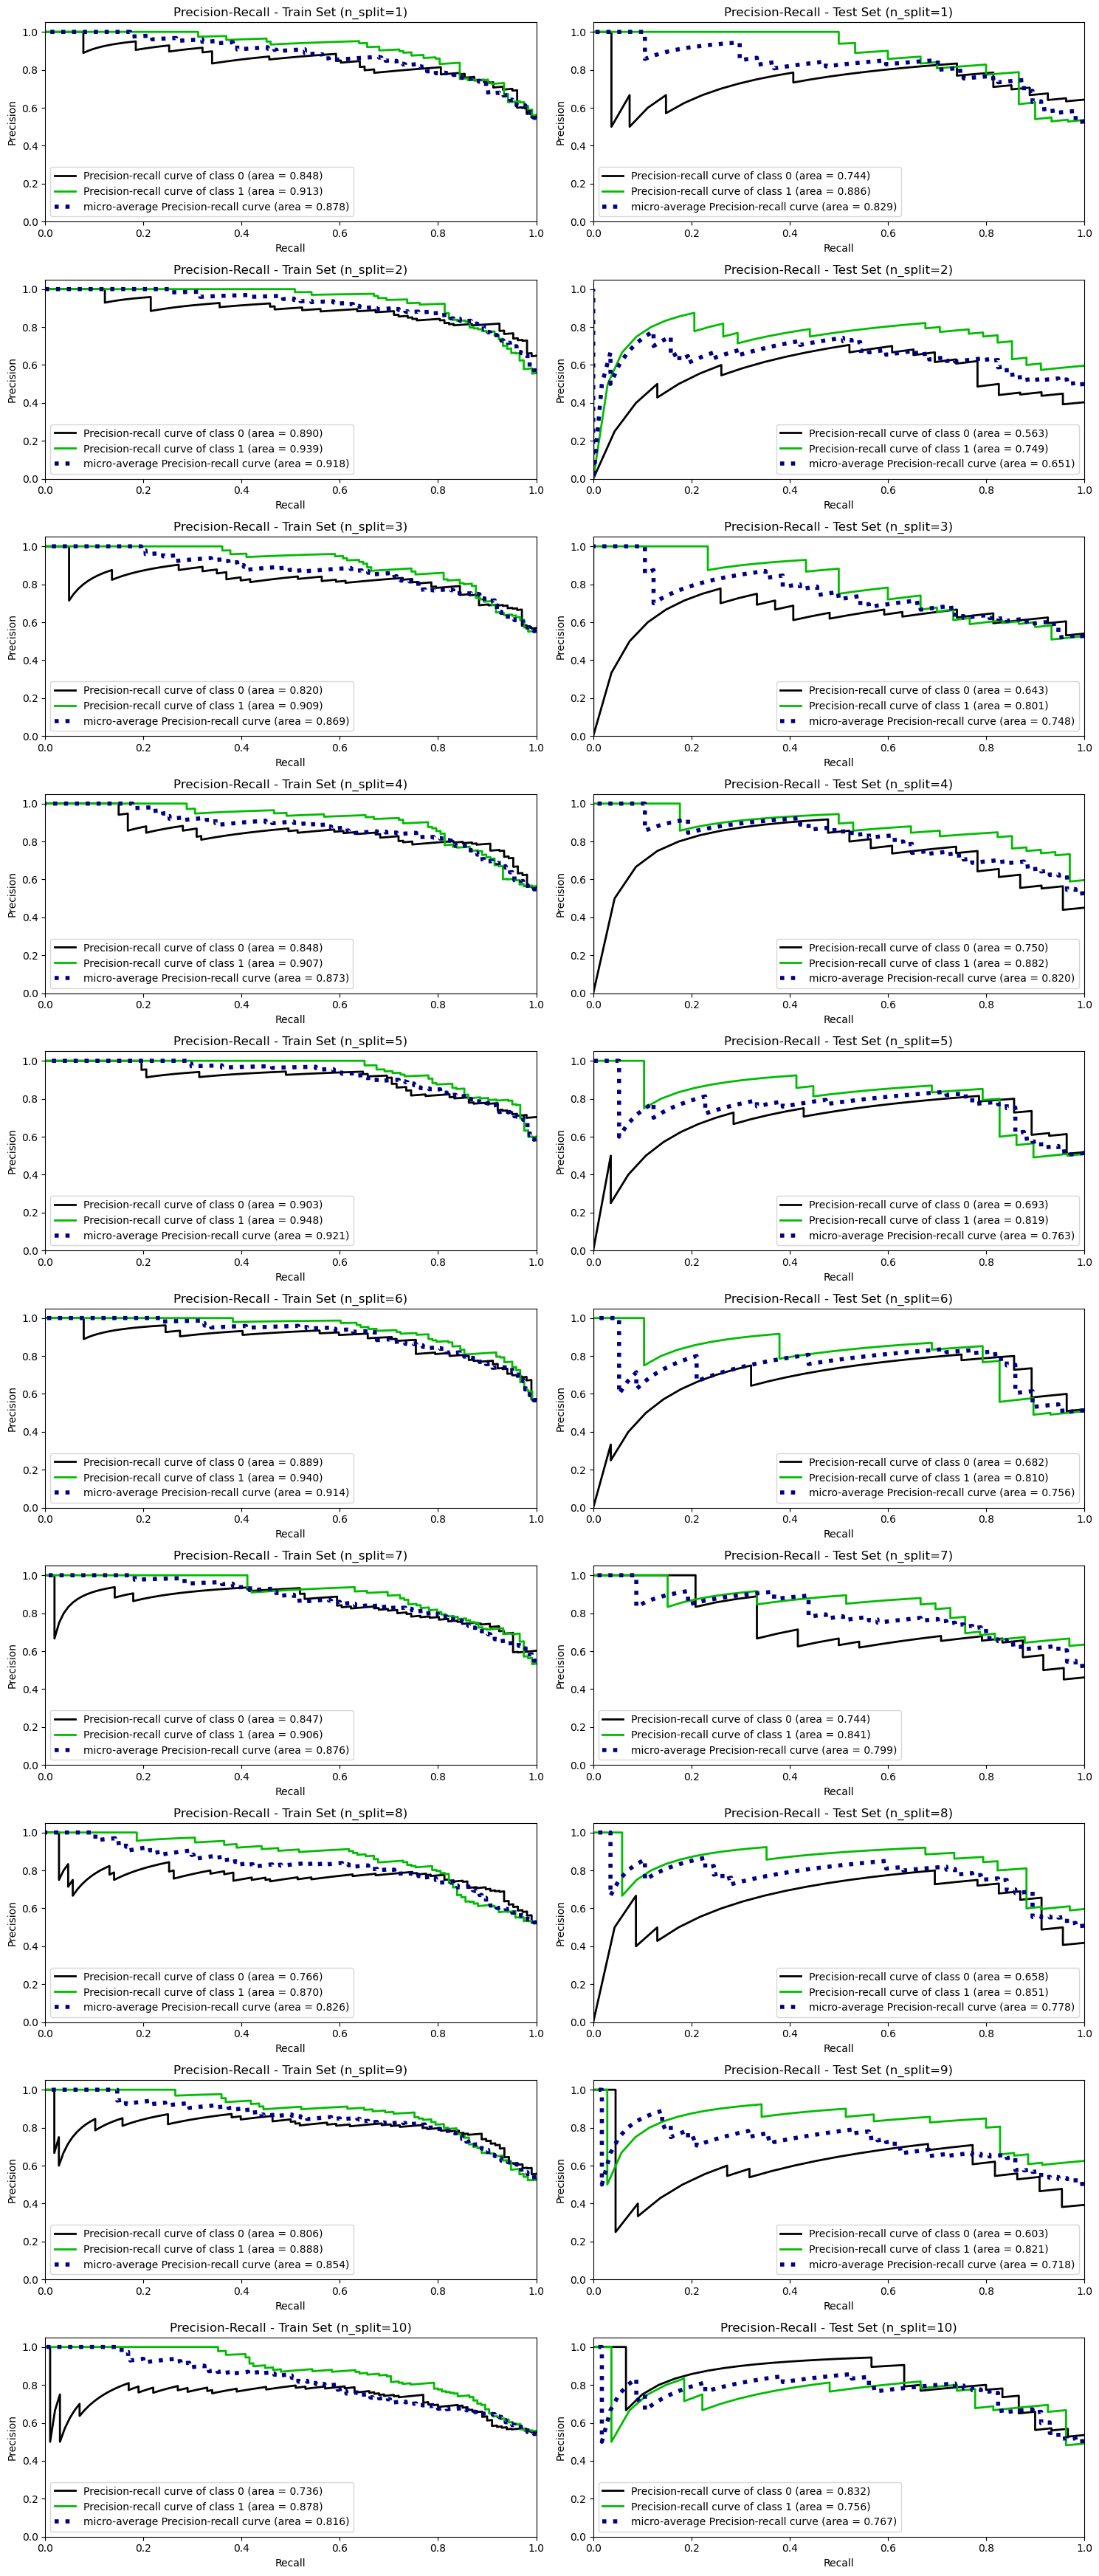

In [27]:
MyMultiTrainTester.plot_precrecall(figsize=(15,35))